In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import math
import numbers
from torch.utils import data
from skimage import io
#3D plot
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [0]:
#put tensor onto GPU
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [0]:
class Plane:
    def __init__(self, o, e, e1, e2, l, w, n):
        """
        o: pinhole 
        e: start from pinhole camera o and ends at the centter of Sensor Board
        e1,e2: axis of the board
        l,w: length and width of the board
        n: sample density of all the points in unit length
        """
        
        self.o = o
        self.e = e
        self.e1 = e1
        self.e2 = e2
        self.l = l
        self.w = w
        self.n = n
        self.sample_num = [self.l * self.n, self.w * self.n]
        
    def get_n(self):
        """return sample x, y and the vector from o to each sample point on the plane"""
        
        ori = torch.empty(self.l * self.n, self.w * self.n, 3)

        for i in range(0, self.l * self.n):
            for j in range(0, self.w * self.n):
                ori[i, j] = self.e + (i / (self.l * self.n) - 0.5)* self.e1 * self.l + (j / (self.w * self.n) - 0.5)* self.e2 * self.w
                
        return ori
         

In [0]:
class Gaussian: 
    
    def __init__(self, c, mu, sigma, albedo):
        '''
        c: (N, g)
        mu: (N, g, 3)
        sigma: (N, g)
        albedo: (N, g, C)
        N: batch size; g: number of gaussians; C: channel
        '''
        self.c = c
        self.mu = mu
        self.sigma = sigma
        self.albedo = albedo
        
    def get_c(self):
#       return torch.sigmoid(self.c) * MAX_C
         return self.c
    
    def get_sigma(self):
#        return torch.sigmoid(self.sigma) * MAX_SIGMA
         return self.sigma
        
    def density(self, x):
        '''
        x: (N, g, H, W, 3)
        return: (N, g, H, W)
        H:height of picture; W: width of picture
        '''
        H = x.size()[2]
        W = x.size()[3]
        
        #c, sigma: (N, g) to (N, g, H, W); mu: (N, g, 3) to (N, g, H, W, 3)
        c = self.get_c().unsqueeze(2).unsqueeze(3).repeat(1, 1, H, W)
        sigma = self.get_sigma().unsqueeze(2).unsqueeze(3).repeat(1, 1, H, W)
        mu = self.mu.unsqueeze(2).unsqueeze(3).repeat(1, 1, H, W, 1)
        
        return c * torch.exp(-1 * torch.norm(x - mu, dim = -1) ** 2 / (2 * sigma ** 2))
    
    def project(self, o, n):
        """
        get new gaussian configuration given o and n
        o: (3)
        n: (H, W, 3)
        return: (N, g, H, W) for new_c, new_mu, new_sigma
        """
        
        H = n.size()[0]
        W = n.size()[1]
        
        n = F.normalize(n, p = 2, dim = -1)     
        new_sigma = self.get_sigma().unsqueeze(2).unsqueeze(3).repeat(1, 1, H, W)
        
        #mu - o: (N, g, 3) to (N, g, H, W, 3)
        mu_o = (self.mu - o).unsqueeze(2).unsqueeze(3).repeat(1, 1, H, W, 1)
        new_mu = (mu_o * n).sum(dim = -1)
        
        #c: (N, g) to (N, g, H, W)
        c = self.get_c().unsqueeze(2).unsqueeze(3).repeat(1, 1, H, W)
        new_c = c * torch.exp(-1 * (mu_o.norm(dim = -1) ** 2 - new_mu ** 2) / 2 / new_sigma ** 2)
        
        return new_c, new_mu, new_sigma

In [0]:
class Space():
    """class of the whole space"""
    
    def __init__(self, gaussians, step = 1):
        '''
        gaussains: all the gaussians in the space
        step: step length when computing visibility
        '''
        self.gaus = gaussians
        self.step = step
        
  
    def transmittance(self, o, n, s):    
        '''
        return the transmittance in position s from o along n
        o: (3, )
        n: (H, W, 3)
        s: (N, g, H, W)
        return: (N, g, H, W)
        '''
        
        t = torch.zeros_like(s)
        n = F.normalize(n, p = 2, dim = -1)
        
        g = s.size()[1]

        #index 2 describes there are g different Gaussians to be considered in each space point, so that we get a density.
        #index 1 describes along every direction(defined by pixels and pinhole), there are g different points to consider along the way

        #s_new: (N, g, H, W) to (N, g, g, H, W)
        s_new = s.unsqueeze(2).repeat(1, 1, g, 1, 1)
        
        #c, mu, sigma: (N, g, H, W) to (N, g, g, H, W)
        c, mu, sigma = self.gaus.project(o, n)
        c = c.unsqueeze(1).repeat(1, g, 1, 1, 1)
        sigma = sigma.unsqueeze(1).repeat(1, g, 1, 1, 1)
        mu = mu.unsqueeze(1).repeat(1, g, 1, 1, 1)
        
        t = sigma * c / np.sqrt(2. / np.pi) * (torch.erf(-1 * mu / np.sqrt(2.) / sigma) - torch.erf((s_new - mu) / np.sqrt(2.) / sigma))
        #t: (N, g, g, H, W) to (N, g, H, W)
        t = t.sum(dim = 2)
            
        return torch.where(s >= 0, torch.exp(t), torch.zeros_like(t))
    
  
    def visibility(self, o, n):
        """
        return the visibility of gaussian g in this space
        o: (3, )
        n: (H, W, 3)
        return: (N, g, H, W)
        """
        
        #n = F.normalize(n, p = 2, dim = -1)
        _, mu, sigma = self.gaus.project(o, n)
        v = torch.zeros_like(mu)
        
        N = sigma.size()[0]
        g = sigma.size()[1]
        
        #sample range: [-4*sigma : 0]; sample step: sigma * self.step
        for i in torch.arange(-4, self.step, self.step):
            s = mu + i * sigma
            v += self.step * sigma * self.transmittance(o, n, s) * self.gaus.density(o + s.unsqueeze(4) * n)
        
        return v
    
    def recv_radiance(self, o, n):
        """
        return received radiance from o in direction n
        o: (3, )
        n: (H, W, 3)
        return: (N, C, H, W)
        """

        n = F.normalize(n, p = 2, dim = -1)
        H = n.size()[0]
        W = n.size()[1]
        C = self.gaus.albedo.size()[2]
        
        #albedo: (N, g, 3) to (N, g, C, H, W)
        albedo = self.gaus.albedo.unsqueeze(3).unsqueeze(4).repeat(1, 1, 1, H, W)
        #vis:(N, g, H, W) to (N, g, C, H, W)
        vis = self.visibility(o, n).unsqueeze(2).repeat(1, 1, C, 1, 1)
        
        #return: (N, g, C, H, W) to (N, C, H, W)
        return (albedo * vis).sum(dim = 1)
    
    def draw(self, plane):
        """project the space on plane"""
        
        V = self.recv_radiance(plane.o, plane.get_n())
            
    
        #draw the plane
        %matplotlib inline
        for i in range(0, V.size()[0]):
            sc = plt.imshow(V[i].detach().cpu().transpose(0, 1).transpose(1, 2), alpha = 0.5)
            plt.show()
        return V    
    

In [0]:
#updated version of data generation, avoid overlapping by enforcing the distance
#between two Gaussians to be more than a threshold
#fix the seed
torch.manual_seed(101)

#training dataset size 
bs_t = 64

#Number of Gaussian 
ng = 1

#manually restrict all Gausssian psf centers to bt within [-10, 10] on x,y axis, 50 on z axis.
mu_xy = torch.randint(-10, 10, [bs_t, 1, 2]).to(torch.float)
mu_z = 50*torch.ones([bs_t, 1, 1]).to(torch.float)
mu = torch.cat((mu_xy, mu_z), dim=-1)

for m in range(ng - 1):
  mu_m = torch.empty(bs_t, 1, 3)
  for n in range(bs_t):
    mu_m[n, :, 0:2] = torch.randint(-10, 10, [2], dtype=torch.float)
    mu_m[n,:,2] = 50*torch.ones([bs_t, 1, 1])
    while True:
      flag = True
      for i in range(mu.size(1)):
        if(torch.dist( mu_m[n,0,0:2], mu[n, i, 0:2] ) < 10.):
          flag = False
          break
      if(flag == True):
        break
      else:
        mu_m[n, :, 0:2] = torch.randint(-10, 10, [2])

  mu = torch.cat((mu, mu_m), dim = 1)

plane = Plane(torch.Tensor([0., 0., -10.]), torch.Tensor([0., 0., 1.]), torch.Tensor([1., 0., 0.]), torch.Tensor([0., 1., 0.]), 2, 2, 32)

c = 5*torch.ones(bs_t, ng)
sigma = torch.randint(7,12,[bs_t,ng])
albedo = 0.7+0.3*torch.rand([bs_t,ng,3])


gau = Gaussian(c,mu,sigma,albedo)
space = Space(gau)
train_data = space.recv_radiance(plane.o,plane.get_n())






#generate validation dataset 

bs_v = 32 #Validation dataset size

mu_xy_v  = torch.randint(-10, 10, [bs_v, 1, 2]).to(torch.float)
mu_z_v = 50*torch.ones([bs_v, 1, 1]).to(torch.float)
mu_v = torch.cat((mu_xy_v, mu_z_v), dim=-1)
for m in range(ng - 1):
  mu_m = torch.empty(bs_v, 1, 3)
  for n in range(bs_v):
    mu_m[n, :, 0:2] = torch.randint(-10, 10, [2], dtype=torch.float)
    mu_m[n,:,2] = 50*torch_ones([bs_v, 1, 1])
    while True:
      flag = True
      for i in range(mu.size(1)):
        if(torch.dist( mu_m[n,0,0:2], mu[n, i, 0:2] ) < 10.):
          flag = False
          break
      if(flag == True):
        break
      else:
        mu_m[n, :, 0:2] = torch.randint(-10, 10, [2])

  mu_v = torch.cat((mu_v, mu_m), dim = -1)

c_v = 5*torch.ones(bs_v, ng)
sigma_v = torch.randint(7,12,[bs_v,ng])
albedo_v = 0.7+0.3*torch.rand([bs_v,ng,3])
gau_v = Gaussian(c_v,mu_v,sigma_v,albedo_v)

space_v = Space(gau_v)
val_data = space_v.recv_radiance(plane.o,plane.get_n())





print(train_data.size())
print(val_data.size())

torch.Size([64, 3, 64, 64])
torch.Size([32, 3, 64, 64])


In [0]:
class GaussianFilter():
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels = 3, kernel_size = 7, sigma = 4, dim=2):
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.weight =  kernel
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def smooth(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        pad_input = F.pad(input, (3,3,3,3), mode = 'replicate')
        mediate = self.conv(pad_input, weight=self.weight, groups=self.groups)
        pad_mediate = F.pad(mediate, (3,3,3,3), mode = 'replicate')
        return self.conv(pad_mediate, weight=self.weight, groups=self.groups)

# smoothing = GaussianFilter(3, 7, 2)
# input = torch.rand(640, 3, 64, 64)
# input = F.pad(input, (3, 3, 3, 3), mode='replicate')
# print(input.size())
# output = smoothing.smooth(input)
# print(output.size())

# gf = GaussianFilter(3,7,3)
# pad_train_data = F.pad(train_data, (3,3,3,3), mode = 'replicate')
# smooth_train_data = gf.smooth(pad_train_data)
# print(smooth_train_data.size())

# pad_val_data = F.pad(val_data, (3,3,3,3), mode = 'replicate')
# smooth_val_data = gf.smooth(pad_val_data)
# print(smooth_val_data.size())

gf = GaussianFilter()
smooth_train_data = gf.smooth(train_data)
smooth_val_data = gf.smooth(val_data)

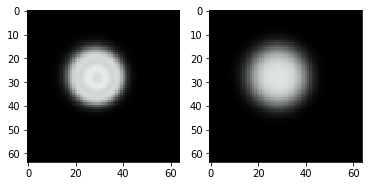

In [0]:
plt.subplot(121)
plt.imshow(train_data[3].cpu().transpose(0,1).transpose(1,2))
plt.subplot(122)
plt.imshow(smooth_train_data[3].cpu().transpose(0,1).transpose(1,2))
plt.show()

In [0]:
class MyDatasetv2(data.Dataset):
  '''Updated Version of Dataset due to large latency between backend storage and computation resource'''
  def __init__(self, images, centers, variances, albedoes):
    self.images = images
    self.centers = centers
    self.variances = variances 
    self.albedoes = albedoes

  def __len__(self):
    return self.centers.size(0)
  
  def __getitem__(self, idx):
    image = self.images[idx]
    center = self.centers[idx]
    variance = self.variances[idx]
    albedo = self.albedoes[idx]
    return image, center, variance, albedo

In [0]:
#create image loader object, v2
#batch size
batch_size = 1
#Number of Gaussians
ng = 1

train_dataset = MyDatasetv2(smooth_train_data, mu, sigma, albedo)
validation_dataset = MyDatasetv2(smooth_val_data, mu_v, sigma_v, albedo_v)
train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = batch_size, shuffle = True)

In [0]:
#define network structure 
class AutoEncoder_v1_2(nn.Module):
    def __init__(self, batch_size, num_gau):
        super(AutoEncoder_v1_2, self).__init__()
        self.bs = batch_size
        self.ng = num_gau
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=4, stride= 4)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels= self.ng, kernel_size=2,stride=2)
        self.fc1 = nn.Linear( self.ng * 64,  self.ng * 32)
        self.fc2 = nn.Linear( self.ng * 32,  self.ng * 16)
        self.fc3 = nn.Linear( self.ng * 16,  self.ng * 2)
    def forward(self,images):
        mu = torch.sigmoid(self.conv1(images))
        mu = torch.sigmoid(self.conv2(mu))
        mu  = mu.view(-1, self.num_flat_features(mu))
        mu = torch.sigmoid(self.fc1(mu))
        #print(mu.size())
        mu = torch.sigmoid(self.fc2(mu))
        mu = torch.sigmoid(self.fc3(mu))
        #print(mu.size())
        mu = torch.unsqueeze(mu, dim = 1)
        centers = 10 * torch.sigmoid(mu).reshape(-1, self.ng, 2)
        #print(centers.size())
        return centers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


autoencoder = AutoEncoder_v1_2(64, 1)
print(autoencoder)

AutoEncoder_v1_2(
  (conv1): Conv2d(3, 3, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(3, 1, kernel_size=(2, 2), stride=(2, 2))
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)


In [0]:
demo_batch_data = torch.randn(64,3,64,64)
ng = 1
conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=4, stride= 4)
conv2 = nn.Conv2d(in_channels=3, out_channels= ng, kernel_size=2,stride=2)
fc1 = nn.Linear( ng * 64,  ng * 32)
fc2 = nn.Linear( ng * 32,  ng * 16)
fc3 = nn.Linear( ng * 16,  ng * 2)
mu = F.relu(conv1(demo_batch_data))
print(mu.size())
mu = F.relu(conv2(mu))
print(mu.size())
mu  = mu.view(-1, 64)
print(mu.size())
mu = F.relu(fc1(mu))
mu = F.relu(fc2(mu))
mu = torch.sigmoid(fc3(mu))
print(mu.size())
mu.unsqueeze_(1)
print(mu.size())
centers = 10 * torch.sigmoid(mu)
centers = torch.cat((centers, 50*torch.ones(64, 1, 1)), dim = -1)
print(centers.size())

torch.Size([64, 3, 16, 16])
torch.Size([64, 1, 8, 8])
torch.Size([64, 64])
torch.Size([64, 2])
torch.Size([64, 1, 2])
torch.Size([64, 1, 3])


In [0]:
#batch size
bs = 1
#Number of Gaussian
ng = 1
#Fix the Plane as before
plane = Plane(torch.Tensor([0., 0., -10.]), torch.Tensor([0., 0., 1.]), torch.Tensor([1., 0., 0.]), torch.Tensor([0., 1., 0.]), 2, 2, 32)
#Fix the magnitude since we don't really train this parameter
c = torch.ones(batch_size, ng) 

#Device specification, maybe unnecessary
device = torch.device("cuda:0")
#epoch number
num_epoch = 10
#learning rate
learning_rate = 0.01
#Loss 
criterion = torch.nn.MSELoss(reduction = 'sum')
optimizer = optim.Adam(autoencoder.parameters())

train_loss_history = []
valid_loss_history = []

import time 
start = time.time()

for epoch in range(num_epoch):
  autoencoder = autoencoder.train() #train mode

  train_loss = 0
  train_n_iter = 0

  for images, centers, variances, albedoes in train_dataloader:
    for mini_epoch in range(10):
        optimizer.zero_grad()
        mu_xy = autoencoder(images)
        #print(mu_xy.size())
        #print(mu_xy)
        mu_t = torch.cat( (mu_xy, 50*torch.ones(bs, ng, 1) ), dim = -1)
        #print(mu_t.size())
        gau_t = Gaussian(c,mu_t,variances,albedoes)
        space_t = Space(gau_t)
        outputs = space_t.recv_radiance(plane.o,plane.get_n())

        #Smooth Processing and Normalization
        smooth_outputs = gf.smooth(outputs) 
        smooth_outputs = (smooth_outputs /torch.max(smooth_outputs) - 0.5)*2

        loss = criterion(torch.exp(smooth_outputs)**3, torch.exp(images) ** 3)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_n_iter += 1
        print('\t mini_epoch ' + str(mini_epoch) + ' finished')      


  # valid_loss = 0
  # valid_n_iter = 0
  # autoencoder = autoencoder.eval()

  # for images, centers, variances, albedoes in validation_dataloader:
  #   images = images.to(device)
  #   centers = centers.to(device)
  #   variances = variances.to(device)
  #   albedoes = albedoes.to(device)
  #   optimizer.zero_grad()
  #   mu_xy = autoencoder(images)
  #   mu_t = torch.cat( (mu_xy, 50*torch.ones(bs, ng, 1) ), dim = -1)
  #   gau_t = Gaussian(c,mu_t,variances,albedoes)
  #   space_t = Space(gau_t)
  #   outputs = space_t.recv_radiance(plane.o,plane.get_n())

  #   #Smooth Processing and Normalization
  #   smooth_outputs = gf.smooth(outputs) 
  #   smooth_outputs = (smooth_outputs /torch.max(smooth_outputs) - 0.5)*2

  #   loss = criterion(torch.exp(smooth_outputs) ** 3, torch.exp(images) ** 3)

  #   valid_loss += loss.item()
  #   valid_n_iter += 1

  train_loss_history.append(train_loss / train_n_iter)
  # valid_loss_history.append(valid_loss / valid_n_iter)

  print('Epoch ' + str(epoch) + ' finished.')


end = time.time()
print('Total training time is: ' + str(end - start))
  


	 mini_epoch 0 finished
	 mini_epoch 1 finished
	 mini_epoch 2 finished
	 mini_epoch 3 finished
	 mini_epoch 4 finished
	 mini_epoch 5 finished
	 mini_epoch 6 finished
	 mini_epoch 7 finished
	 mini_epoch 8 finished
	 mini_epoch 9 finished
	 mini_epoch 0 finished
	 mini_epoch 1 finished
	 mini_epoch 2 finished
	 mini_epoch 3 finished
	 mini_epoch 4 finished
	 mini_epoch 5 finished
	 mini_epoch 6 finished
	 mini_epoch 7 finished
	 mini_epoch 8 finished
	 mini_epoch 9 finished
	 mini_epoch 0 finished
	 mini_epoch 1 finished
	 mini_epoch 2 finished
	 mini_epoch 3 finished
	 mini_epoch 4 finished
	 mini_epoch 5 finished
	 mini_epoch 6 finished
	 mini_epoch 7 finished
	 mini_epoch 8 finished
	 mini_epoch 9 finished
	 mini_epoch 0 finished
	 mini_epoch 1 finished
	 mini_epoch 2 finished
	 mini_epoch 3 finished
	 mini_epoch 4 finished
	 mini_epoch 5 finished
	 mini_epoch 6 finished
	 mini_epoch 7 finished
	 mini_epoch 8 finished
	 mini_epoch 9 finished
	 mini_epoch 0 finished
	 mini_epoch 1 f

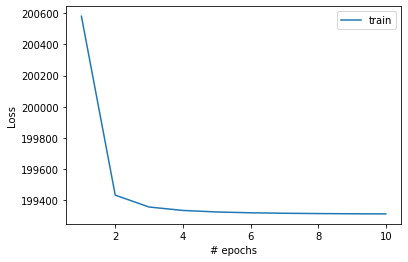

In [0]:
# Plot training and validation curve
x = range(1, num_epoch + 1)
plt.plot(x, train_loss_history, label='train')
#plt.plot(x, valid_loss_history, label='valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

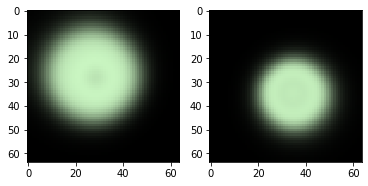

In [0]:
plt.subplot(121)
plt.imshow(images[0].detach().cpu().transpose(0,1).transpose(1,2))
plt.subplot(122)
plt.imshow(outputs[0].detach().cpu().transpose(0,1).transpose(1,2))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


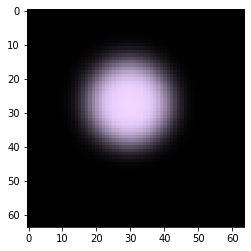

tensor([[[5.0003, 5.0002]]], grad_fn=<MulBackward0>)
tensor([[[-7., -7., 50.]]])


In [0]:
image = smooth_train_data[24]
plt.imshow(image.detach().cpu().transpose(0,1).transpose(1,2))
plt.show()

autoencoder = autoencoder.eval()
mu_t = autoencoder(torch.unsqueeze(image, 0))
print(mu_t)
print(centers)